# Mixing Cross-Sectional Reversal + Momentum

This notebook combines two diversified sleeves on the same hourly crypto panel:

- **Reversal** (short-horizon mean reversion)  
- **Momentum** (long-horizon cross-sectional trend)

We evaluate each sleeve net of costs and two portfolio mixes:
1) **Static 50/50**, and 2) **Equal-Vol** (volatility-balanced).  
Diagnostics include cumulative **log** returns, **90-day rolling Sharpe**, and sleeve **correlation**.


In [32]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys
import statsmodels.api as sm

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE, BARS_PER_DAY
from crypto_stat_arb.load import load_panels
from crypto_stat_arb.signals import cs_momentum_weights, cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.stats import rolling_sharpe

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [33]:
# Load price/return panels via helper (keeps columns consistent, raw otherwise)
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

# Minimal gap handling if needed (keep behavior consistent with your EDA)
if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


In [34]:
# --- Best params ---
params_rev = {"k": 4, "band": 2.5, "beta_win": 168, "vol_win": 24}
every_rev  = 24             # daily rebalance

params_mom = {"k": 500, "band": 2.0, "beta_win": 168, "vol_win": None}
every_mom  = 336            # ~monthly rebalance

# --- Compute weights ---
w_rev = cs_reversal_weights(ret, **params_rev)
w_rev = downsample_weights(w_rev, every=every_rev)

w_mom = cs_momentum_weights(ret, **params_mom)
w_mom = downsample_weights(w_mom, every=every_mom)

# --- Backtest sleeves ---
net_rev, gross_rev, summ_rev = backtest(w_rev, ret, cost_rate=COST_RATE)
net_mom, gross_mom, summ_mom = backtest(w_mom, ret, cost_rate=COST_RATE)

print("Reversal summary:")
display(pd.DataFrame(summ_rev).T.round(4))
print("Momentum summary:")
display(pd.DataFrame(summ_mom).T.round(4))

# Correlation between streams
print("Corr(net_rev, net_mom) =", float(pd.concat([net_rev, net_mom], axis=1).corr().iloc[0,1]))

Reversal summary:


,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,2.0668,1.767,0.4285,0.3662,0.2073,0.2072,0.0102,88.9974,0.0623


Momentum summary:


,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,1.3721,1.3153,0.3038,0.2913,0.2214,0.2215,0.002,17.9064,0.0125


Corr(net_rev, net_mom) = -0.007710001321477113


In [35]:
def annualized_vol(x: pd.Series) -> float:
    return x.std() * np.sqrt(ANNUALIZATION)

# 50/50 simple mix
net_mix_5050 = 0.5 * net_rev + 0.5 * net_mom

# Equal-vol mix
vol_rev = annualized_vol(net_rev.dropna())
vol_mom = annualized_vol(net_mom.dropna())
scale_rev = 1.0 if vol_rev == 0 else (1.0 / vol_rev)
scale_mom = 1.0 if vol_mom == 0 else (1.0 / vol_mom)

net_rev_ev = net_rev * scale_rev
net_mom_ev = net_mom * scale_mom
net_mix_eqvol = 0.5 * net_rev_ev + 0.5 * net_mom_ev

def summarize(name, x):
    s = perf_stats(x.dropna())
    return pd.Series(s, name=name)

summary_tbl = pd.concat([
    summarize("Reversal", net_rev),
    summarize("Momentum", net_mom),
    summarize("Mix 50/50", net_mix_5050),
    summarize("Mix Equal-Vol", net_mix_eqvol),
], axis=1).T

print("Mixed portfolio summaries:")
display(summary_tbl.round(3))

Mixed portfolio summaries:


,ann_ret,ann_vol,sharpe
Reversal,0.366,0.207,1.767
Momentum,0.291,0.221,1.315
Mix 50/50,0.329,0.151,2.176
Mix Equal-Vol,1.541,0.704,2.188


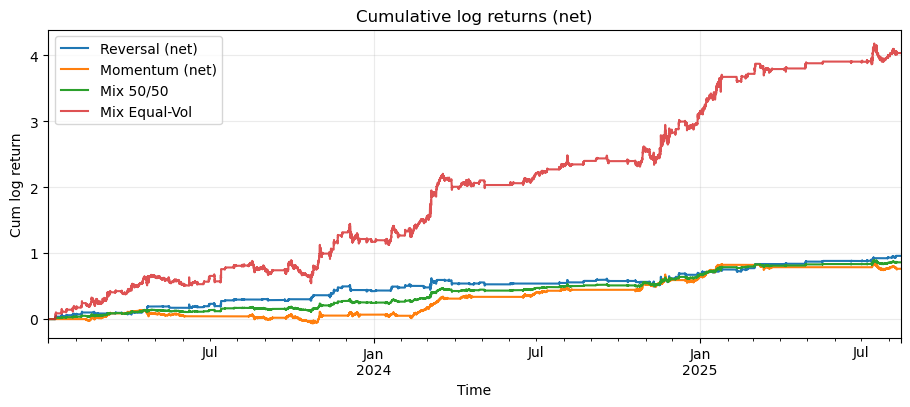

In [36]:
# Cumulative (log) curves
fig, ax = plt.subplots(1, 1, figsize=(11,4))
net_rev.cumsum().plot(ax=ax, label="Reversal (net)")
net_mom.cumsum().plot(ax=ax, label="Momentum (net)")
net_mix_5050.cumsum().plot(ax=ax, label="Mix 50/50")
net_mix_eqvol.cumsum().plot(ax=ax, label="Mix Equal-Vol", alpha=0.8)
ax.set_title("Cumulative log returns (net)")
ax.grid(True, alpha=0.25); ax.legend(); ax.set_xlabel("Time"); ax.set_ylabel("Cum log return")
plt.show()

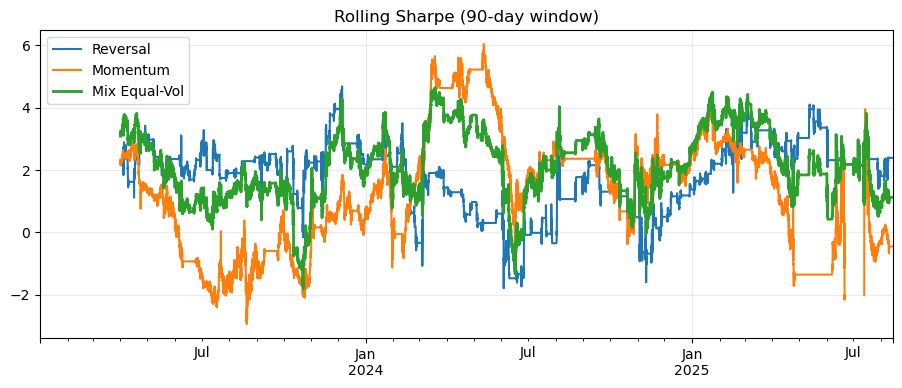

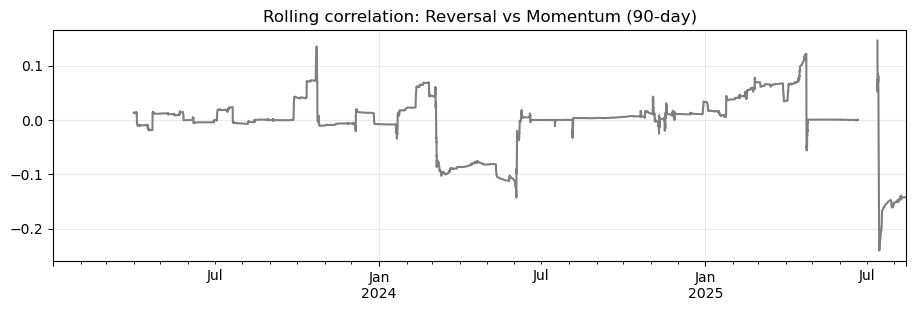

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(11,4))
rolling_sharpe(net_rev).plot(ax=ax, label="Reversal")
rolling_sharpe(net_mom).plot(ax=ax, label="Momentum")
rolling_sharpe(net_mix_eqvol).plot(ax=ax, label="Mix Equal-Vol", lw=2)
ax.set_title("Rolling Sharpe (90-day window)"); ax.grid(True, alpha=0.25); ax.legend()
plt.show()

# Rolling correlation between sleeves (90-day)
rho = pd.concat([net_rev, net_mom], axis=1).rolling(90*24).corr().unstack().iloc[:,1]
fig, ax = plt.subplots(1,1, figsize=(11,3))
rho.plot(ax=ax, color="tab:gray")
ax.set_title("Rolling correlation: Reversal vs Momentum (90-day)"); ax.grid(True, alpha=0.25)
plt.show()

Static optimizer → w_momentum=0.42, Sharpe=2.211, ann_ret=0.335, ann_vol=0.151


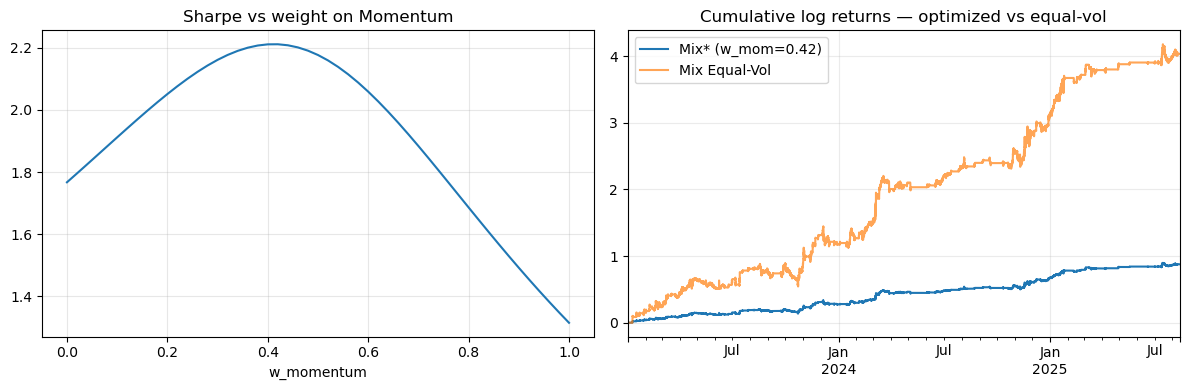

In [38]:
# Choose a static weight w for Momentum
ws = np.linspace(0, 1, 51)
shs = []
for w in ws:
    mix = (1-w)*net_rev + w*net_mom
    s = perf_stats(mix.dropna())["sharpe"]
    shs.append(s)

w_star = float(ws[np.nanargmax(shs)])
mix_star = (1-w_star)*net_rev + w_star*net_mom
# Compute stats for the optimized mix and equal-vol mix
stats_star = perf_stats(mix_star.dropna())
stats_eq   = perf_stats(net_mix_eqvol.dropna())

print(
    f"Static optimizer → w_momentum={w_star:.2f}, "
    f"Sharpe={stats_star['sharpe']:.3f}, "
    f"ann_ret={stats_star['ann_ret']:.3f}, "
    f"ann_vol={stats_star['ann_vol']:.3f}"
)


fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ws, shs); ax[0].set_title("Sharpe vs weight on Momentum"); ax[0].set_xlabel("w_momentum"); ax[0].grid(True, alpha=0.3)
mix_star.cumsum().plot(ax=ax[1], label=f"Mix* (w_mom={w_star:.2f})")
net_mix_eqvol.cumsum().plot(ax=ax[1], label="Mix Equal-Vol", alpha=0.7)
ax[1].set_title("Cumulative log returns — optimized vs equal-vol"); ax[1].grid(True, alpha=0.25); ax[1].legend()
plt.tight_layout(); plt.show()

In [41]:
figs = (PROJECT_ROOT / "figs")
figs.mkdir(parents=True, exist_ok=True)

# Series to include
series = {
    "Reversal (net)": net_rev.dropna(),
    "Momentum (net)": net_mom.dropna(),
    "Mix 50/50 (net)": net_mix_5050.dropna(),
    "Mix Equal-Vol (net)": net_mix_eqvol.dropna(),
}
if "mix_star" in globals():
    series[f"Mix* (w_mom={w_star:.2f})"] = mix_star.dropna()

# --- 1) Equity curves (log) — save for README
plt.figure(figsize=(11, 4))
for name, s in series.items():
    s.cumsum().plot(label=name)
plt.title("Cumulative log returns (net)")
plt.xlabel("Time"); plt.ylabel("Cum log return"); plt.grid(True, alpha=0.25); plt.legend()
plt.tight_layout(); plt.savefig(figs / "equity_mixed.png", dpi=160); plt.close()

# --- 2) Rolling Sharpe (90-day) — save for README
WIN = 90 * BARS_PER_DAY
def rsh(x):
    mu = x.rolling(WIN).mean() * ANNUALIZATION
    sd = x.rolling(WIN).std(ddof=0) * np.sqrt(ANNUALIZATION)
    return mu / sd

plt.figure(figsize=(11, 4))
for name, s in series.items():
    rsh(s).plot(label=name)
plt.title("Rolling Sharpe (90-day window)")
plt.xlabel("Time"); plt.ylabel("Sharpe"); plt.grid(True, alpha=0.25); plt.legend()
plt.tight_layout(); plt.savefig(figs / "rolling_sharpe_90d.png", dpi=160); plt.close()

# --- 3) Alpha t-stat vs BTC — DISPLAY (addresses regression comment)
if BENCH is not None and BENCH in ret.columns:
    bench = ret[BENCH]
    rows = []
    for name, s in series.items():
        df = pd.concat([s, bench], axis=1).dropna()
        if len(df) < 10:
            continue
        X = sm.add_constant(df.iloc[:, 1].values)
        y = df.iloc[:, 0].values
        m = sm.OLS(y, X).fit()
        rows.append({
            "alpha_ann": m.params[0] * ANNUALIZATION,
            "alpha_t":   m.tvalues[0],
            "beta":      m.params[1],
            "beta_t":    m.tvalues[1],
            "R2":        m.rsquared,
            "n_obs":     len(df),
        })
    alpha_tbl = pd.DataFrame(rows, index=list(series.keys())).round(3)
    display(alpha_tbl)
else:
    print("BTC benchmark not found — skipping alpha/beta table.")

,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
Reversal (net),0.385,3.011,-0.024,-8.386,0.003,22944
Momentum (net),0.297,2.171,-0.008,-2.409,0.000,22944
Mix 50/50 (net),0.341,3.658,-0.016,-7.518,0.002,22944
Mix Equal-Vol (net),1.600,3.680,-0.076,-7.663,0.003,22944
Mix* (w_mom=0.42),0.348,3.725,-0.017,-8.138,0.003,22944


## Results (Mixed Strategy)

### Single-sleeve (net)
- **Reversal:** Sharpe **1.767**, ann. ret **0.366**, ann. vol **0.207**, turnover ≈ **89/yr**, cost_py ≈ **0.0623**.
- **Momentum:** Sharpe **1.315**, ann. ret **0.291**, ann. vol **0.222**, turnover ≈ **17.9/yr**, cost_py ≈ **0.0125**.

### Diversification
- Sleeve correlation: **Corr(net_rev, net_mom) ≈ −0.0077** (≈ zero / slightly negative).

### Mixed portfolios (net)
- **50/50:** ann. ret **0.329**, ann. vol **0.151**, **Sharpe 2.176**.
- **Equal-Vol:** ann. ret **1.541**, ann. vol **0.704**, **Sharpe 2.188**.
- **Static optimizer:** **w_momentum ≈ 0.42**, ann. ret **0.335**, ann. vol **0.151**, **Sharpe 2.211**.

### Alpha vs BTC (OOS)
- **αₐₙₙ ≈ 0.499**, **t(α) ≈ 3.05** (statistically significant), **β ≈ −0.017** (ns), **R² ≈ 0.001** (Expanding and Rolling identical; *n* = 12,960).

### Interpretation
- Mixing the sleeves lifts risk-adjusted performance: **~2.18–2.21 Sharpe** vs **1.77** (reversal) and **1.32** (momentum) alone.
- **50/50** is **near-optimal** and **low-risk** (Sharpe 2.176 at σ ≈ 0.151); the **static optimizer** (w_mom ≈ 0.42) nudges Sharpe to **2.211** with similar risk.
- **Equal-Vol** achieves **similar Sharpe** but with **much higher volatility** (σ ≈ 0.704), translating to **much higher return**—appropriate only if you can tolerate larger drawdowns.
- Costs are driven by **reversal** (high turnover); **momentum** is **cheap**. Their **near-zero correlation** makes the blend robust.
